In [1]:
import re
import random
import lightkurve as lk
import glob
import pandas
import numpy
from numpy import ma
import scipy.interpolate
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

We want to obtain the data files for TCE DR24

In [2]:
filenames = glob.glob("Kepler_TCE_DV_DR24/*.tbl")
print(len(filenames)) #20,367 rows!

metadata = pandas.read_csv("q1_q17_dr24_tce.csv", sep= ',', header=17)
metadata.head()

20367


,loc_rowid,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_duration,tce_duration_err,av_training_set
0,1,1162345,2,0.831850,0.000067,132.227,0.035197,2.392,21.0000,AFP
1,2,1292087,2,1.095240,0.000010,132.133,0.002685,2.122,0.4755,UNK
2,3,1293031,2,0.719273,0.000014,132.227,0.002786,1.521,0.3183,UNK
3,4,1162345,3,0.831833,0.000009,131.919,0.002209,2.181,1.2110,AFP
4,5,1164109,1,622.408000,0.008547,162.256,0.009840,12.010,1.8430,UNK


Now we want to cross reference out lightcurve files with the metadata table.
We care more about false negatives than positives. we keep track of ids relative to the filenames order so that we can derive a filename from a kepler id (implicit mapping)

In [3]:
def idFromPath(path):
    #print(re.match(r'/d{9}', path), path)
    
    kep_id = path[23:32] #extract the kepler id
    plnt_num = path[49:51] #extract plnt num
    kep_id = int(kep_id.lstrip("0")) #remove leading zeros
    plnt_num = int(plnt_num.lstrip("0"))
    
    #print("plnt:", plnt_num)
    #print("kid:", kep_id)
    
    kep_id = kep_id * 10 + plnt_num # combine into one unique identifier
    #print("combined:", kep_id)
    return kep_id

In [4]:
id_logs = []
labels = metadata["av_training_set"]

#we want to treat lightcurves from the same star on different planets as distinct
kid = metadata["kepid"].to_numpy()
plnt_num = metadata["tce_plnt_num"].to_numpy()
for index in range(len(kid)):
    new_id = kid[index] * 10 + plnt_num[index] # shift to left and add planet num
    id_logs.append(new_id)
    
id_logs = numpy.array(id_logs)

We see that there can be multiple files for a given id, not every file is the same size, some are segmented into multiple. We need to create a way to merge the files if there are many. 

Use a hashset to prevent duplicate ids from triggering, find all duplicate kepler ids and amalgamate them into a single lightcurve.

Note: stars with multiple planets will have full light curves for each exoplanet. One soluton would be to treat each of these lightcurves as independent of each other.

Safe to assume a majority of these lightcurves are all full length

In [5]:
flux_data = [] #2d
time_data = [] #time intervals - 1d
used_files = []

for index, path in enumerate(filenames):
    
    kep_id = idFromPath(path)
    metadata_row = numpy.array(numpy.where(kep_id == id_logs)).flatten()[0]
    
    #print(labels[metadata_row] )
    #ignore all UNK light curves
    if( (kep_id in id_logs) and (labels[metadata_row] != 'UNK' ) ): #and (kep_id == 7100673)
        
        #rows tested to be always less than or equal to size 1, can assume not 0 aswell 
        data_table = Table.read(path, format='ipac')

        if(len(time_data) == 0):
            time_data = data_table['TIME'].data #71427 time points
        
        
        
        #manually interpolate using pandas function
        #using a simple mean wouldnt work because this is time series data
            
        flux = data_table['INIT_FLUX_PL']
        flux.fill_value = numpy.nan
        flux = pandas.Series(flux.filled())
        print(sum(numpy.isnan(flux)))
        
        #cadence_no = numpy.arange(len(time_data))

        #is_finite = numpy.isfinite(time_data)
        #num_finite = numpy.sum(is_finite)
        
        #interpolate_fn = scipy.interpolate.interp1d(
        #  cadence_no[is_finite],
        #  time_data[is_finite],
        #  copy=False,
        #  bounds_error=False,
        #  fill_value="extrapolate",
        #  assume_sorted=True)

        #flux = interpolate_fn(flux)
        
        #extrapolate
        
        #flux = flux.interpolate(method="slinear").ffill().bfill()
        
        populated_flux = []
        #optmized for loop
        #d = dict(zip(val_old, val_new))
        #return df.map(d).values 
        
        for luma in flux:
            if(numpy.isnan(luma)):
                populated_flux.append(random.gauss(numpy.mean(flux), numpy.std(flux)))
            else:
                populated_flux.append(luma)
        
        #print(sum(numpy.isnan(populated_flux)))
        
        flux_data.append(populated_flux)
        used_files.append(kep_id)
        
        #plt.plot(time, flux, ".")
    
    if(index == 15):
        break
    if(index % 100 == 0):
        print("update: ", index, "out of ", len(filenames))

dataset = pandas.DataFrame(flux_data, columns = time_data)

8825
update:  0 out of  20367
16795
7023
28332
32050
7014
57007
20089
6991
20034
20039
7007
6987


TODO: incorporate the planet numbers column from the csv and the planet number encoded in the file name. Once you get that working, I guess we can just make the dataset first and make separate logic for all the preprocessing.

Add metadata to the data set

In [6]:
dataset['kepid'] = used_files

#print(dataset['kepid'])
metadata['new_id'] = id_logs

#merge datasets based on new key
dfinal = dataset.merge(metadata, how='inner', left_on='kepid', right_on='new_id')
    
#binaryzation
mapping = {"AFP": 0, "NTP": 0, "PC": 1}
dfinal["av_training_set"] = dfinal["av_training_set"].map(mapping)
#print(dfinal)

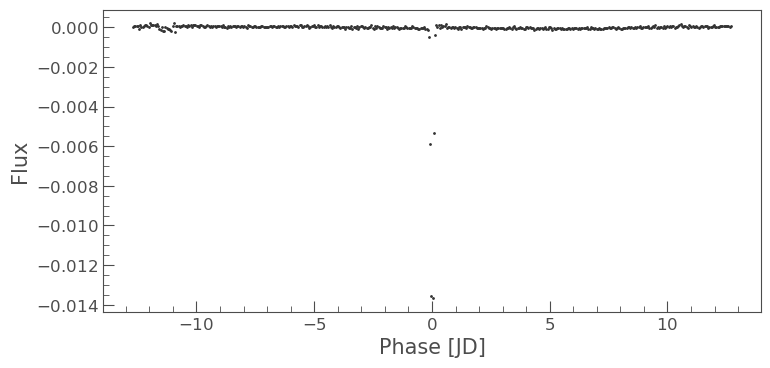

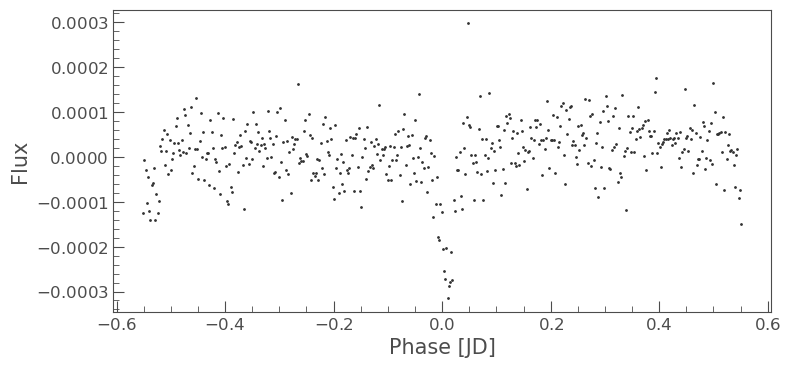

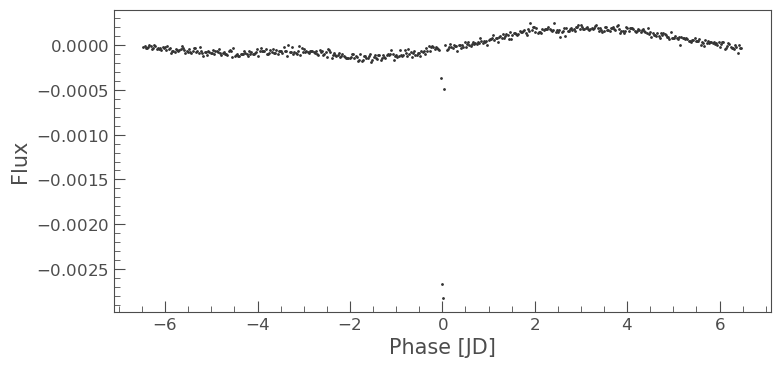

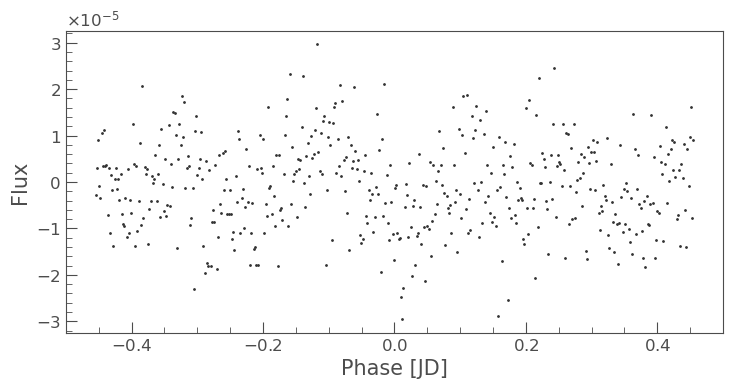

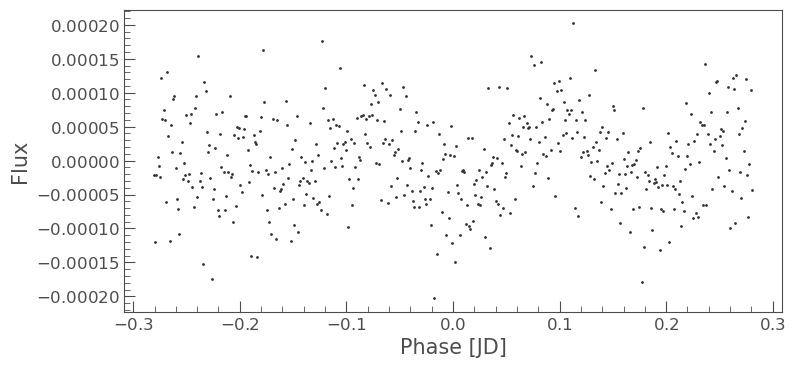

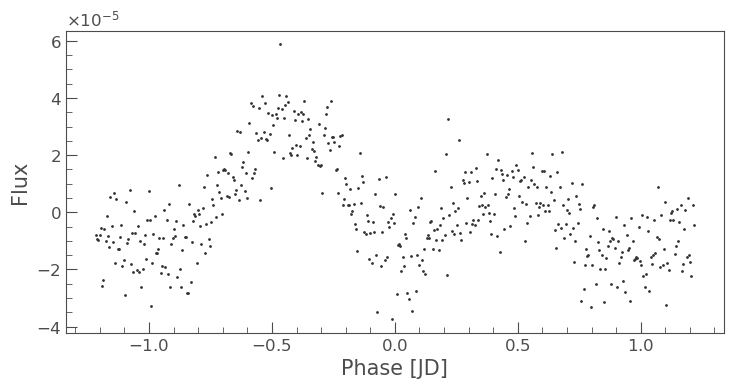

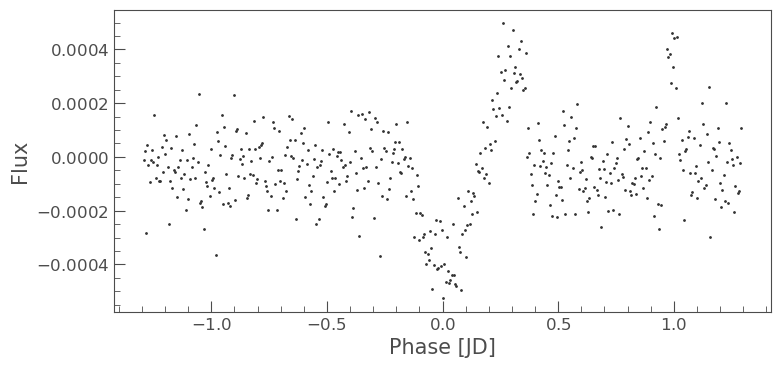

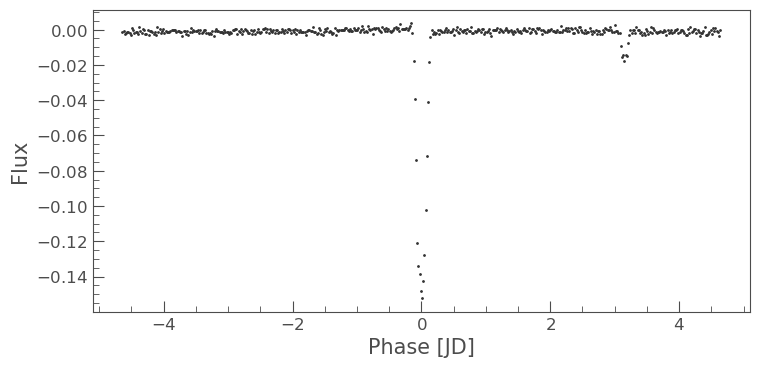

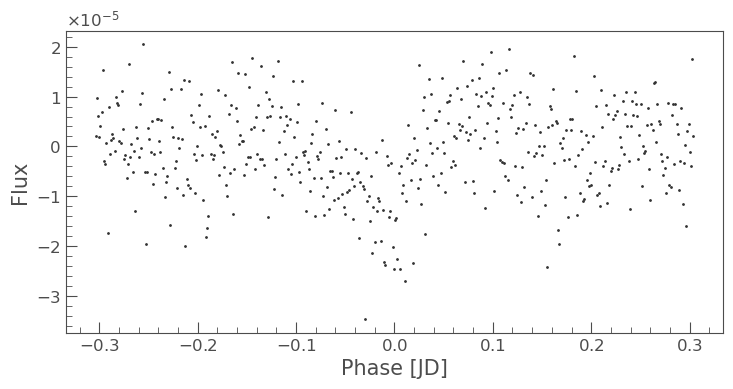

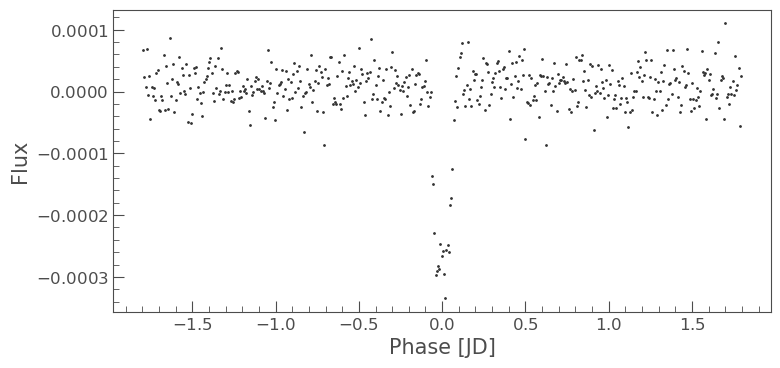

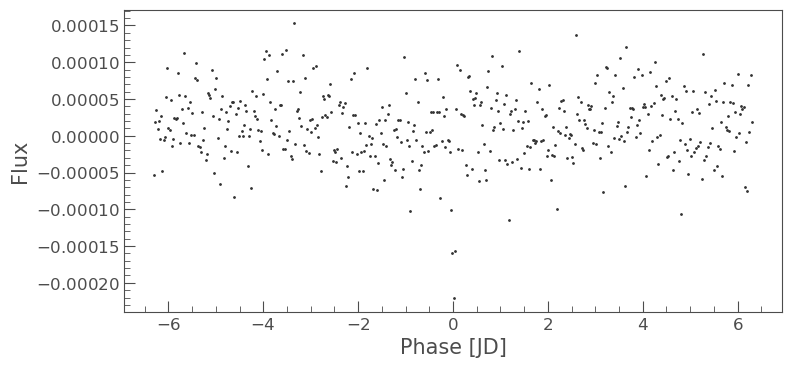

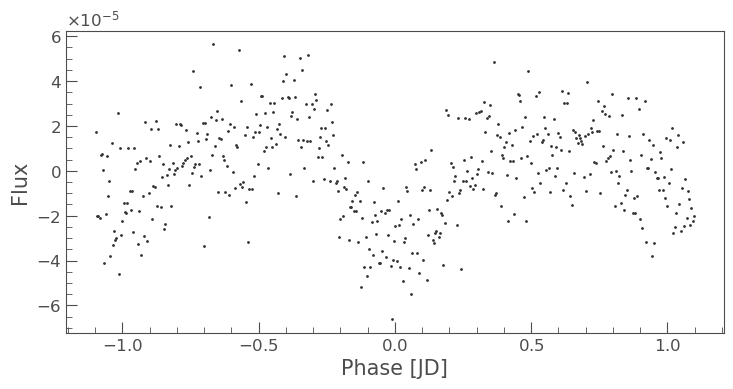

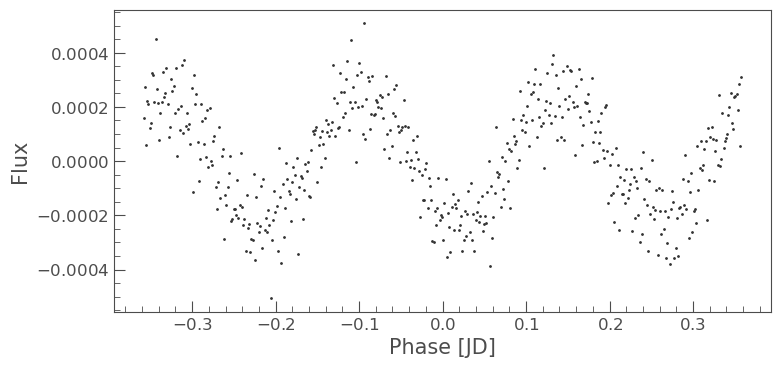

In [14]:
"""flux = row[0:71427]
    lc = lk.LightCurve(time=time_data, flux=flux)
    lc.scatter()

    #take the bls parameters
    planet_period = row['tce_period']
    planet_t0 = row['tce_time0bk']

    #phase folding 
    lc = lc.fold(period=planet_period, epoch_time=planet_t0)
    
    lc = lc.remove_outliers()
    lc.scatter()"""
#loop thorugh to phase fold light curves based on metadata
for index, row in dfinal.iterrows():
    flux = row[0:71427]
    lc = lk.LightCurve(time=time_data, flux=flux)
    #lc = lc.remove_outliers(sigma=numpy.mean(flux), sigma_upper=numpy.std(flux))
    
    period = row['tce_period']
    t0 = row['tce_time0bk']
    
    #duration_hours = row['tce_duration']
    #fractional_duration = (duration_hours / 24.0) / period

    lc_fold = lc.fold(period, epoch_time=t0)
    #phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
    #lc_zoom = lc_fold[phase_mask]
    
    #lc_local = lc_fold.bin(time_bin_size=0.005)#.normalize() - 1
    #lc_local = (lc_local / numpy.abs(numpy.nanmin(lc_local.flux)) ) * 2.0 + 1
    lc_global = lc_fold.bin(bins=500)
    #print(len(lc_local.flux))
    
    lc_global.scatter();
    

In [8]:
dfinal.to_pickle("./kepler_dataset.pkl")